
![](img/banner.png)
%%HTML
<script src="require.js"></script>

# Lecture 3: Kernel Trick

**Making linear models non-linear**

**Mahmood Amintoosi, Spring 2024**

Computer Science Dept, Ferdowsi University of Mashhad

I should mention that the original material of this course was from [Open Machine Learning Course](https://ml-course.github.io/), by [Joaquin Vanschoren](https://github.com/joaquinvanschoren) and others.

> **Note:** Kernel trick, which is also known as *[kernel method](https://en.wikipedia.org/wiki/Kernel_method)* or *kernel machines* are a class of algorithms for pattern analysis, where involve using linear classifiers to solve nonlinear problems. These methods are different from *[kernelization](https://en.wikipedia.org/wiki/Kernelization)*, that is a technique for designing efficient algorithms that achieve their efficiency by a preprocessing stage in which inputs to the algorithm are replaced by a smaller input, called a "kernel".


In [1]:
# Auto-setup when running on Google Colab
import os
if 'google.colab' in str(get_ipython()) and not os.path.exists('/content/machine-learning'):
    !git clone -q https://github.com/fum-cs/machine-learning.git /content/machine-learning
    !pip --quiet install -r /content/machine-learning/requirements_colab.txt
    %cd machine-learning/notebooks

# Global imports and settings
%matplotlib inline
from preamble import *
interactive = True # Set to True for interactive plots
if interactive:
    fig_scale = 0.5
    plt.rcParams.update(print_config)
else: # For printing
    fig_scale = 1.3
    plt.rcParams.update(print_config)

## Feature Maps
* Linear models: $\hat{y} = \mathbf{w}\mathbf{x} + w_0 = \sum_{i=1}^{p} w_i x_i + w_0 = w_0 + w_1 x_1 + ... + w_p x_p $  

* When we cannot fit the data well, we can add non-linear transformations of the features
* Feature map (or _basis expansion_ ) $\phi$ : $ X \rightarrow \mathbb{R}^d $

$$y=\textbf{w}^T\textbf{x} \rightarrow  y=\textbf{w}^T\phi(\textbf{x})$$  

* E.g. Polynomial feature map: all polynomials up to degree $d$ and all products

$$[1, x_1, ..., x_p] \xrightarrow{\phi} [1, x_1, ..., x_p, x_1^2, ..., x_p^2, ..., x_p^d, x_1 x_2, ..., x_{p-1} x_p]$$

* Example with $p=1, d=3$ :

$$y=w_0 + w_1 x_1 \xrightarrow{\phi} y=w_0 + w_1 x_1 + w_2 x_1^2 + w_3 x_1^3$$  


### Ridge regression example

Weights: [0.418]


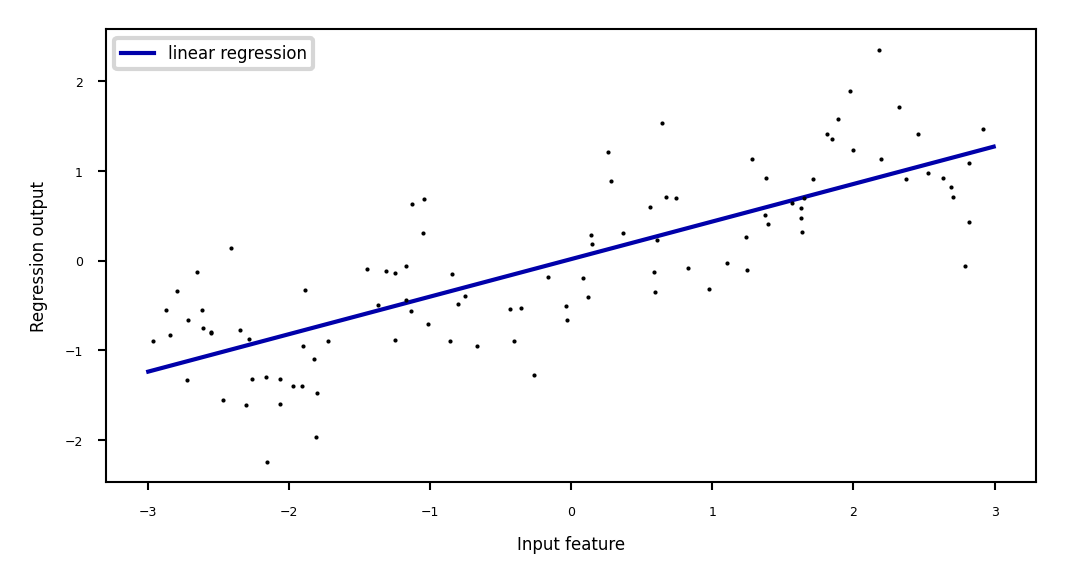

In [2]:
from sklearn.linear_model import Ridge

X, y = mglearn.datasets.make_wave(n_samples=100)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)
reg = Ridge().fit(X, y)
print("Weights:",reg.coef_)
fig = plt.figure(figsize=(8*fig_scale,4*fig_scale))
plt.plot(line, reg.predict(line), label="linear regression", lw=2*fig_scale)

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best");

* Add all polynomials $x^d$ up to degree 10 and fit again:
    * e.g. use sklearn `PolynomialFeatures`

In [3]:
from sklearn.preprocessing import PolynomialFeatures

# include polynomials up to x ** 10:
# the default "include_bias=True" adds a feature that's constantly 1
poly = PolynomialFeatures(degree=10, include_bias=False)
poly.fit(X)
X_poly = poly.transform(X)
styles = [dict(selector="td", props=[("font-size", "150%")]),dict(selector="th", props=[("font-size", "150%")])]
pd.DataFrame(X_poly, columns=poly.get_feature_names_out()).head().style.set_table_styles(styles)

,x0,x0^2,x0^3,x0^4,x0^5,x0^6,x0^7,x0^8,x0^9,x0^10
0,-0.752759,0.566647,-0.426548,0.321088,-0.241702,0.181944,-0.136960,0.103098,-0.077608,0.058420
1,2.704286,7.313162,19.776880,53.482337,144.631526,391.124988,1057.713767,2860.360362,7735.232021,20918.278410
2,1.391964,1.937563,2.697017,3.754150,5.225640,7.273901,10.125005,14.093639,19.617834,27.307312
3,0.591951,0.350406,0.207423,0.122784,0.072682,0.043024,0.025468,0.015076,0.008924,0.005283
4,-2.063888,4.259634,-8.791409,18.144485,-37.448187,77.288869,-159.515582,329.222321,-679.478050,1402.366700


Weights: [ 0.643  0.297 -0.69  -0.264  0.41   0.096 -0.076 -0.014  0.004  0.001]


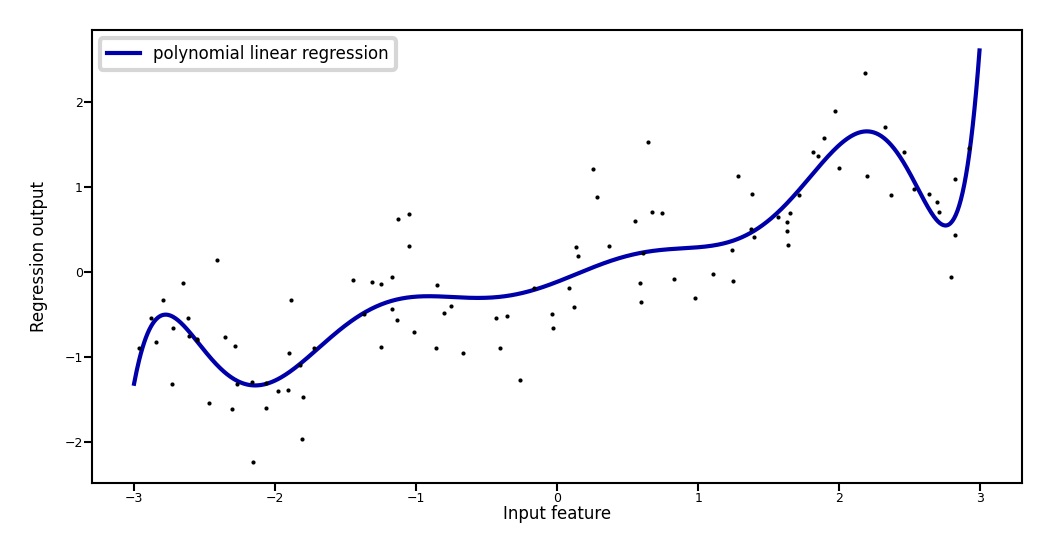

In [4]:
reg = Ridge().fit(X_poly, y)
print("Weights:",reg.coef_)
line_poly = poly.transform(line)
fig = plt.figure(figsize=(8*fig_scale,4*fig_scale))
plt.plot(line, reg.predict(line_poly), label='polynomial linear regression', lw=2*fig_scale)
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature", labelpad=0.1)
plt.tick_params(axis='both', pad=0.1)
plt.legend(loc="best");

#### How expensive is this?

* You may need MANY dimensions to fit the data
    * Memory and computational cost
    * More weights to learn, more likely overfitting
* Ridge has a closed-form solution which we can compute with linear algebra:
$$w^{*} = (X^{T}X + \alpha I)^{-1} X^T Y$$

* Since X has $n$ rows (examples), and $d$ columns (features), $X^{T}X$ has dimensionality $d x d$
* Hence Ridge is quadratic in the number of features, $\mathcal{O}(d^2n)$
* After the feature map $\Phi$, we get
$$w^{*} = (\Phi(X)^{T}\Phi(X) + \alpha I)^{-1} \Phi(X)^T Y$$

* Since $\Phi$ increases $d$ a lot, $\Phi(X)^{T}\Phi(X)$ becomes _huge_

### Linear SVM example (classification)

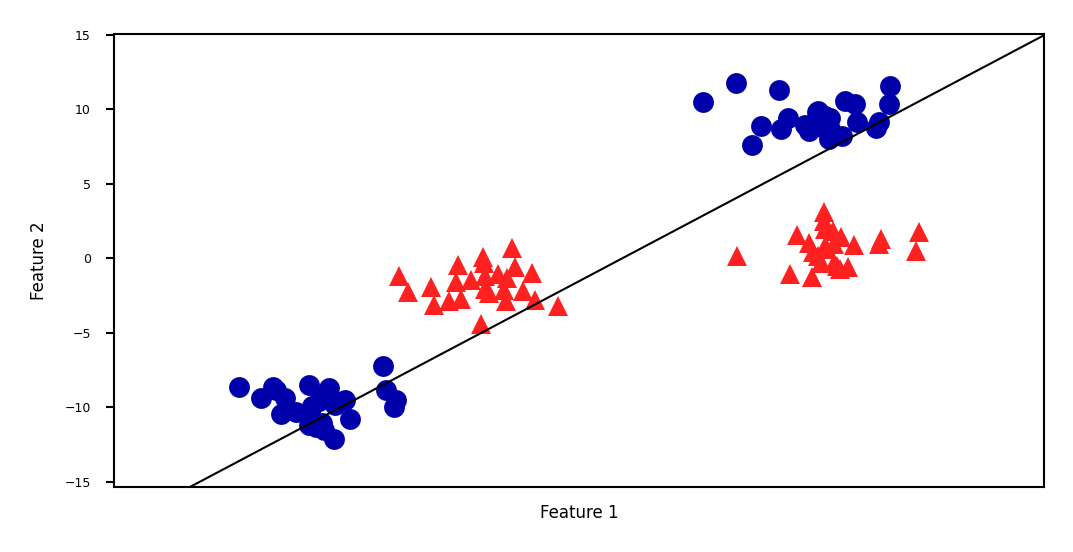

In [5]:
from sklearn.datasets import make_blobs
from sklearn.svm import LinearSVC
X, y = make_blobs(centers=4, random_state=8)
y = y % 2
linear_svm = LinearSVC().fit(X, y)

fig = plt.figure(figsize=(8*fig_scale,4*fig_scale))
mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y, s=10*fig_scale)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2");

We can add a new feature by taking the squares of feature1 values

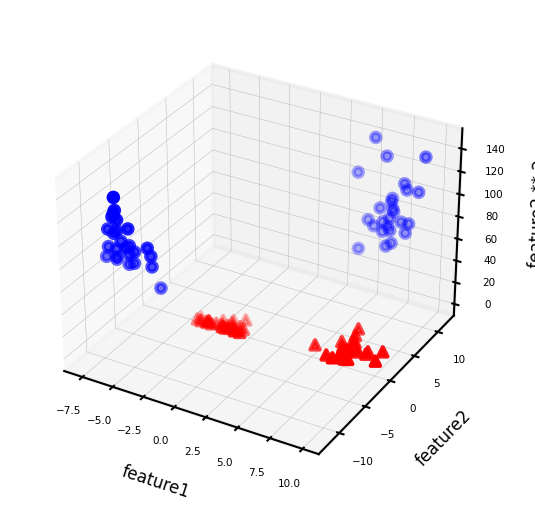

In [6]:
# add the squared first feature
X_new = np.hstack([X, X[:, 1:] ** 2])

# visualize in 3D
fig = plt.figure(figsize=(8*fig_scale,4*fig_scale))
ax = fig.add_subplot(111, projection='3d')

# plot first all the points with y==0, then all with y == 1
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=10*fig_scale)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=10*fig_scale)
ax.set_xlabel("feature1", labelpad=-9)
ax.set_ylabel("feature2", labelpad=-9)
ax.set_zlabel("feature2 ** 2", labelpad=-9);
ax.tick_params(axis='both', width=0, labelsize=5*fig_scale, pad=-3)

Now we can fit a linear model

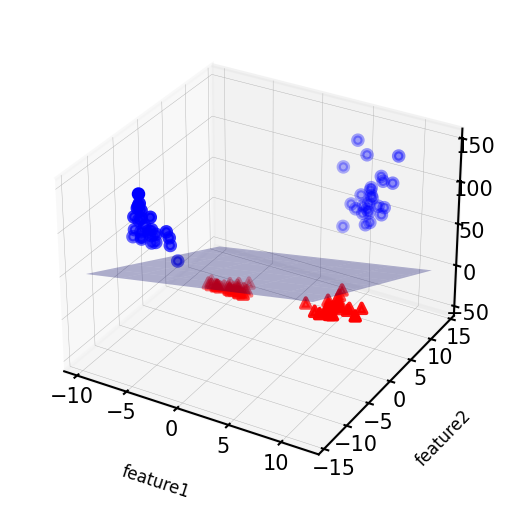

In [7]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# show linear decision boundary
fig = plt.figure(figsize=(8*fig_scale,4*fig_scale))
ax = fig.add_subplot(111, projection='3d')
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=10*fig_scale)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=10*fig_scale)

ax.set_xlabel("feature1", labelpad=-9)
ax.set_ylabel("feature2", labelpad=-9)
ax.set_zlabel("feature2 ** 2", labelpad=-9);
ax.tick_params(axis='both', width=0, labelsize=10*fig_scale, pad=-6)

As a function of the original features, the decision boundary is now a polynomial as well
$$y = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_2^2 > 0$$

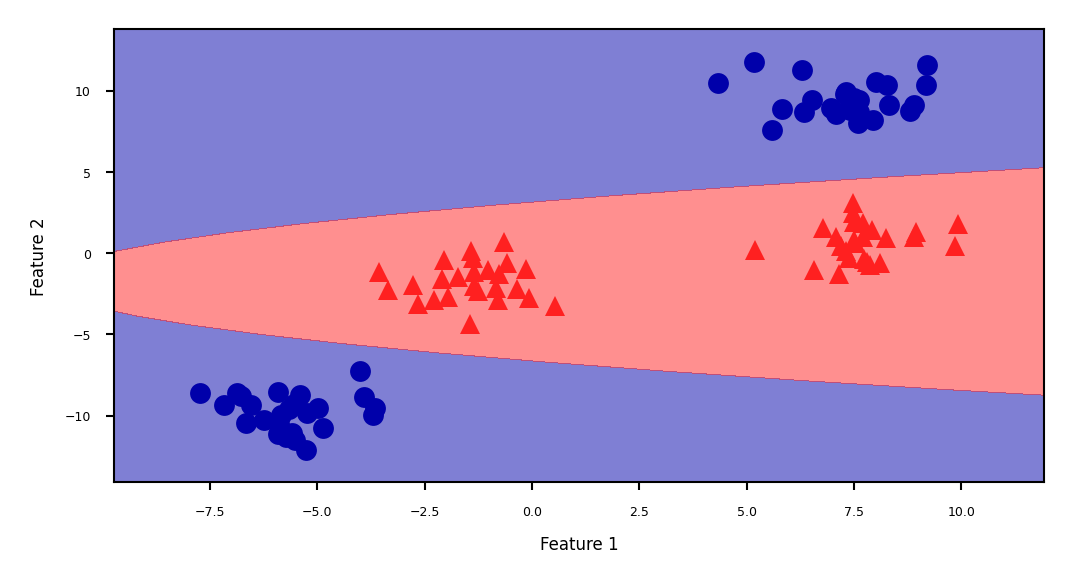

In [8]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
figure = plt.figure(figsize=(8*fig_scale,4*fig_scale))
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y, s=10*fig_scale)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2"); 

## The kernel trick
* Computations in explicit, high-dimensional feature maps are _expensive_
* For _some_ feature maps, we can, however, compute _distances_ between _points_ cheaply
    * Without explicitly constructing the high-dimensional space at all
* Example: _quadratic_ feature map for $\mathbf{x} = (x_1,..., x_p )$:

$$ \Phi(\mathbf{x}) = (x_1,..., x_p , x_1^2,..., x_p^2 , \sqrt{2} x_1 x_2 , ..., \sqrt{2} x_{p-1} x_{p}) $$

* A _kernel function_ exists for this feature map to compute dot products

$$ k_{quad}(\mathbf{x_i},\mathbf{x_j}) =  \Phi(\mathbf{x_i}) \cdot \Phi(\mathbf{x_j}) =  \mathbf{x_i} \cdot \mathbf{x_j} + (\mathbf{x_i} \cdot \mathbf{x_j})^2$$

* Skip computation of $\Phi(x_i)$ and $\Phi(x_j)$ and compute $k(x_i,x_j)$ directly

## Kernel Method

* Kernel $k$ corresponding to a feature map $\Phi$: $ k(\mathbf{x_i},\mathbf{x_j}) = \Phi(\mathbf{x_i}) \cdot \Phi(\mathbf{x_j})$
* Computes dot product between $x_i,x_j$ in a high-dimensional space $\mathcal{H}$
    * Kernels are sometimes called _generalized dot products_
    * $\mathcal{H}$ is called the _reproducing kernel Hilbert space_ (RKHS)
* The dot product is a measure of the _similarity_ between $x_i,x_j$
    * Hence, a kernel can be seen as a similarity measure for high-dimensional spaces
* If we have a loss function based on dot products $\mathbf{x_i}\cdot\mathbf{x_j}$ it can be _kernelized_
    * Simply replace the dot products with $k(\mathbf{x_i},\mathbf{x_j})$

<img src="https://raw.githubusercontent.com/fum-cs/machine-learning/main/notebooks/img/RKHS.png" alt="ml" style="margin: 0 auto; width: 900px;"/>

# Chapter 5 of Zaki book

- [Zaki book](https://fumdrive.um.ac.ir/index.php/s/9W96bM8Q3QaJpAM)
- [Slides of Chap. 5](https://www.cs.rpi.edu/~zaki/DMML/slides/pdf/ychap5.pdf)

## Kernel K-Means
- [Slides of Chap. 13](https://www.cs.rpi.edu/~zaki/DMML/slides/pdf/ychap13.pdf)

## Other examples

- For Kernel PCA, see [section 7.3 of Zaki Book]((https://www.cs.rpi.edu/~zaki/DMML/slides/pdf/ychap7.pdf))
- For Kernel SMV and Kernel Regression see [Appendix A](AppenixA-Kernel-SVM-and-Kernel-Regression.ipynb)
    * [MIT, Lecture on Kernel Regression](https://web.mit.edu/modernml/course/lectures/MLClassLecture3.pdf)

## Summary
* Feature maps $\Phi(x)$ transform features to create a higher-dimensional space
    * Allows learning non-linear functions or boundaries, but very expensive/slow
* For some $\Phi(x)$, we can compute dot products without constructing this space
    * Kernel trick: $k(\mathbf{x_i},\mathbf{x_j}) = \Phi(\mathbf{x_i}) \cdot \Phi(\mathbf{x_j})$
    * Kernel $k$ (generalized dot product) is a measure of similarity between $\mathbf{x_i}$ and $\mathbf{x_j}$
* There are many such kernels
    * Polynomial kernel: $k_{poly}(\mathbf{x_1},\mathbf{x_2}) = (\gamma (\mathbf{x_1} \cdot \mathbf{x_2}) + c_0)^d$
    * RBF (Gaussian) kernel: $k_{RBF}(\mathbf{x_1},\mathbf{x_2}) = exp(-\gamma ||\mathbf{x_1} - \mathbf{x_2}||^2)$
    * A kernel matrix can be precomputed using any similarity measure (e.g. for text, graphs,...)
* Any loss function where inputs appear only as dot products can be kernelized
    * E.g. Linear SVMs: simply replace the dot product with a kernel of choice
* The Representer theorem states which _other_ loss functions can also be kernelized and how
    * Ridge regression, Logistic regression, Perceptrons,...